In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import sklearn
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from scikitplot.metrics import plot_roc_curve
from imblearn.under_sampling import RandomUnderSampler
from itertools import product
from sklearn.cluster import MiniBatchKMeans
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
import random
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, silhouette_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
import scipy.stats as stats
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

In [3]:
df=pd.read_csv(r"C:\Users\conta\OneDrive\Desktop\General Assembly\Projects\project-capstone\Credit cards\CleanEDAfraud.csv")
df.head()

,category,amt,gender,city_pop,is_fraud,trans_day,trans_month,trans_hour,trans_year,age_at_trans,dist
0,misc_net,4.97,F,3495,0,Tuesday,January,0,2019,20-30,40-50
1,grocery_pos,107.23,F,149,0,Tuesday,January,0,2019,30-40,10-20
2,entertainment,220.11,M,4154,0,Tuesday,January,0,2019,50-60,60 - 70
3,gas_transport,45.00,M,1939,0,Tuesday,January,0,2019,50-60,50-60
4,misc_pos,41.96,M,99,0,Tuesday,January,0,2019,30-40,40-50


In [4]:
#Checking percentage of fraud and non-fraud transactions
#Baseline is 0.994 non-fraud transactions
df.is_fraud.value_counts(normalize=True)

0    0.99479
1    0.00521
Name: is_fraud, dtype: float64

In [5]:
# Creating dummy variables for Category

X = pd.get_dummies(df, columns=['category', 'gender', 'trans_year', 'trans_day', 'trans_month', 'trans_hour', 'age_at_trans', 'dist'],drop_first=True)
y = X.pop('is_fraud')

In [6]:
# Split your data X and y, into a training and a test set and fit the pipeline onto the training data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

### Logistic Regression
- Logistic Regression is one of the most used ML algorithms in binary classification
- Can be adjusted reasonably well to work on imbalanced data...useful for fraud detection

In [7]:
lr = LogisticRegression(random_state=42, solver='liblinear', penalty='l2')
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_train)
test_pred_lr = lr.predict(X_test)
print('Accuracy Train Score:', accuracy_score(y_train, pred_lr))
print('Accuracy Test Score:', accuracy_score(y_test, test_pred_lr))
print('5 Cross val score:', cross_val_score(lr, X_train, y_train, cv=5))
print('Cross val score:', cross_val_score(lr, X_train, y_train, cv=5).mean())

Accuracy Train Score: 0.9943517072512388
Accuracy Test Score: 0.9943928496236407
5 Cross val score: [0.99450518 0.99455916 0.99452831 0.99433166 0.99445505]
Cross val score: 0.9944758709776929


In [8]:
print(confusion_matrix(y_train, pred_lr))
print(classification_report(y_train, pred_lr))

[[1289351     568]
 [   6756       0]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00   1289919
           1       0.00      0.00      0.00      6756

    accuracy                           0.99   1296675
   macro avg       0.50      0.50      0.50   1296675
weighted avg       0.99      0.99      0.99   1296675



###  On unbalance data Logictic Regression detected  0 fraud cases even Accuracy score high.  The number of samples for class 1 is less tha 0.5% of the samples of class 0. In this case the the machine learning algorithms with not predict the Fraud cases correctly. To predict the Fraud correctly I will use a SMOTE method for oversampling minority class, but It increases the likelihood of overfitting since it replicates the minority class events.

In [9]:
# Resampling the minority class

sm = SMOTE(sampling_strategy='minority', random_state=42)
# Fit the model to generate the data.
X_train_os, y_train_os = sm.fit_resample(X, y)
print(f'Original dataset shape:\n{ y.value_counts()}')
print(f'Resample dataset shape:\n{ y_train_os.value_counts()}')

Original dataset shape:
0    1842743
1       9651
Name: is_fraud, dtype: int64
Resample dataset shape:
1    1842743
0    1842743
Name: is_fraud, dtype: int64


In [10]:
y_test.value_counts()

0    552824
1      2895
Name: is_fraud, dtype: int64

In [11]:
X_test.shape

(555719, 72)

### Logistic Regression RUS

In [56]:
lr = LogisticRegression(random_state=42, solver='liblinear', penalty='l2')
lr.fit(X_rus, y_rus)
pred_lr = lr.predict(X_rus)
test_pred_lr = lr.predict(X_test)
print('Accuracy Train Score:', accuracy_score(y_rus, pred_lr))
print('Accuracy Test Score:', accuracy_score(y_test, test_pred_lr))
print('5 Cross val score:', cross_val_score(lr, X_rus, y_rus, cv=5))
print('Cross val score:', cross_val_score(lr, X_rus, y_rus, cv=5).mean())

Accuracy Train Score: 0.887161952129313
Accuracy Test Score: 0.8733910483535744
5 Cross val score: [0.81973582 0.84175084 0.8611399  0.81606218 0.84585492]
Cross val score: 0.8369087312610629


In [57]:
print(f'Confusion Matrix:\n{confusion_matrix(y_test, test_pred_lr)}')
print(f'Classification Report:\n{classification_report(y_test, test_pred_lr)}')

Confusion Matrix:
[[482758  70066]
 [   293   2602]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93    552824
           1       0.04      0.90      0.07      2895

    accuracy                           0.87    555719
   macro avg       0.52      0.89      0.50    555719
weighted avg       0.99      0.87      0.93    555719



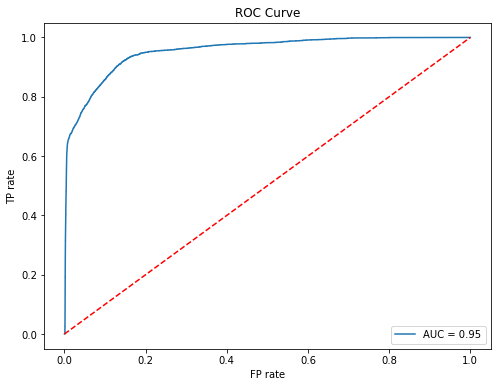

In [58]:
# Plotting Test ROC 
y_pred = lr.predict_proba(X_test)[:,1]
fp_r, tp_r, t = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fp_r, tp_r)
plt.figure(figsize=(8, 6))
plt.plot(fp_r, tp_r, label="AUC = %.2f" % auc)
plt.plot([0,1],[0,1],"r--")
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.legend(loc=4)
plt.title("ROC Curve")
plt.show()

### SMOTE LOGICTIC REGRESSION

In [12]:
lr = LogisticRegression(random_state=42, solver='liblinear', penalty='l2')
lr.fit(X_train_os, y_train_os)
pred_lr = lr.predict(X_train_os)
test_pred_lr = lr.predict(X_test)
print('Accuracy Train Score:', accuracy_score(y_train_os, pred_lr))
print('Accuracy Test Score:', accuracy_score(y_test, test_pred_lr))
print('5 Cross val score:', cross_val_score(lr, X_train_os, y_train_os, cv=5))
print('Cross val score:', cross_val_score(lr, X_train_os, y_train_os, cv=5).mean())

Accuracy Train Score: 0.985080393739116
Accuracy Test Score: 0.9863132266487199
5 Cross val score: [0.96879248 0.98172696 0.98533165 0.98330206 0.98558534]
Cross val score: 0.9809476992058084


In [13]:
print(confusion_matrix(y_train_os, pred_lr))
print(classification_report(y_train_os, pred_lr))

[[1823637   19106]
 [  35880 1806863]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99   1842743
           1       0.99      0.98      0.99   1842743

    accuracy                           0.99   3685486
   macro avg       0.99      0.99      0.99   3685486
weighted avg       0.99      0.99      0.99   3685486



### With Logistic Regression(SMOTE) train, 1,806,863  out of 1,842,743 fraud cases are detected, 35,880 are not detected, and 19,106 false positives are identified. F1 score almost the same to Train and Cross Val Score.

In [14]:
print(f'Confusion Matrix:\n{confusion_matrix(y_test, test_pred_lr)}')
print(f'Classification Report:\n{classification_report(y_test, test_pred_lr)}')

Confusion Matrix:
[[547138   5686]
 [  1920    975]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    552824
           1       0.15      0.34      0.20      2895

    accuracy                           0.99    555719
   macro avg       0.57      0.66      0.60    555719
weighted avg       0.99      0.99      0.99    555719



#### Logistic Regression on test score about 20% trustable occurring F1 score

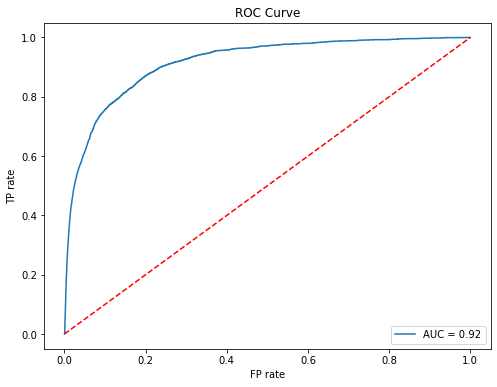

In [15]:
# Plotting Test ROC 
y_pred = lr.predict_proba(X_test)[:,1]
fp_r, tp_r, t = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fp_r, tp_r)
plt.figure(figsize=(8, 6))
plt.plot(fp_r, tp_r, label="AUC = %.2f" % auc)
plt.plot([0,1],[0,1],"r--")
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.legend(loc=4)
plt.title("ROC Curve")
plt.show()

#### DecisionTreeClassifier SMOTE
- Commonly used for fraud detection
- Decision trees are prone to overfit the data

In [18]:
dtc = DecisionTreeClassifier(criterion = 'gini', max_depth = 20, random_state=42)
dtc.fit(X_train_os, y_train_os)
pred_dtc = dtc.predict(X_train_os)
pred_dtc_test = dtc.predict(X_test)
print('Accuracy Train Score:', accuracy_score(y_train_os, pred_dtc))
print('Accuracy Test Score:', accuracy_score(y_test, pred_dtc_test))
print('5 Cross val score:', cross_val_score(dtc, X_train_os, y_train_os, cv=5))
print('Cross val score:', cross_val_score(dtc, X_train_os, y_train_os, cv=5).mean())

Accuracy Train Score: 0.9864465636282433
Accuracy Test Score: 0.980306593800104
5 Cross val score: [0.71203965 0.7548708  0.86016223 0.95866487 0.97359099]
Cross val score: 0.8518657077590472


#### Cross val score showing that the Decision Tree model can be overfitted

In [19]:
print(f'Confusion Matrix:\n{confusion_matrix(y_train_os, pred_dtc)}')
print(f'Classification Report:\n{ classification_report(y_train_os, pred_dtc)}')

Confusion Matrix:
[[1807059   35684]
 [  14267 1828476]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99   1842743
           1       0.98      0.99      0.99   1842743

    accuracy                           0.99   3685486
   macro avg       0.99      0.99      0.99   3685486
weighted avg       0.99      0.99      0.99   3685486



In [20]:
print(f'Confusion Matrix:\n{confusion_matrix(y_test, pred_dtc_test)}')
print(f'Classification Report:\n{classification_report(y_test, pred_dtc_test)}')

Confusion Matrix:
[[542071  10753]
 [   191   2704]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    552824
           1       0.20      0.93      0.33      2895

    accuracy                           0.98    555719
   macro avg       0.60      0.96      0.66    555719
weighted avg       1.00      0.98      0.99    555719



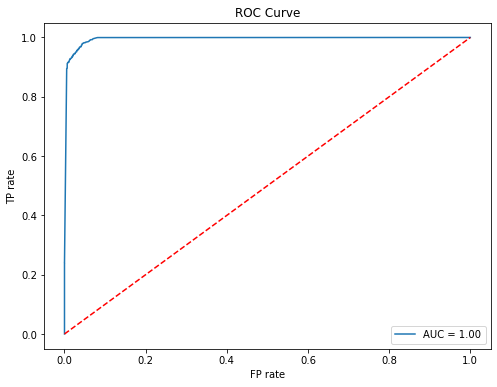

In [21]:
y_pred = dtc.predict_proba(X_test)[:,1]
fp_r, tp_r, t = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fp_r, tp_r)
plt.figure(figsize=(8, 6))
plt.plot(fp_r, tp_r, label="AUC = %.2f" % auc)
plt.plot([0,1],[0,1],"r--")
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.legend(loc=4)
plt.title("ROC Curve")
plt.show()

### Random Forests are a more robust option than a single decision tree
- Construct a multitude of decision trees when training the model and outputting the class that is the mode or mean predicted -- class of the individual trees
- A random forest consists of a collection of trees on a random subset of features
- Final predictions are the combined results of those trees
- Random forests can handle complex data and are not prone to overfit
- They are interpretable by looking at feature importance, and can be adjusted to work well on highly imbalanced data
- Their drawback is they're computationally complex
- Very popular for fraud detection

### Random Forest on imbalance data just to see the difference

In [23]:

rfc = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=5, max_features=12,
                             min_samples_leaf=100, random_state=100)
rfc.fit(X_train, y_train)
pred_rfc = rfc.predict(X_train)
pred_rfc_test = rfc.predict(X_test)
print('Accuracy Train Score:', accuracy_score(y_train, pred_rfc))
print('Accuracy Test Score:', accuracy_score(y_test, pred_rfc_test))
print('5 Cross val score:', cross_val_score(rfc, X_train, y_train, cv=5))
print('Cross val score:', cross_val_score(rfc, X_train, y_train, cv=5).mean())

Accuracy Train Score: 0.994789750708543
Accuracy Test Score: 0.9947905326253016
5 Cross val score: [0.99479052 0.99479052 0.99479052 0.99479052 0.99478667]
Cross val score: 0.994789750708543


In [24]:
print(f'Confusion Matrix:\n{confusion_matrix(y_train, pred_rfc)}')
print(f'Classification Report:\n{ classification_report(y_train, pred_rfc)}')

Confusion Matrix:
[[1289919       0]
 [   6756       0]]


C:\Users\conta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00   1289919
           1       0.00      0.00      0.00      6756

    accuracy                           0.99   1296675
   macro avg       0.50      0.50      0.50   1296675
weighted avg       0.99      0.99      0.99   1296675



### Random Forest works bad for imbalance data will apply SMOTE

In [25]:
#Building a Random Forest Model
rfc_sm = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=5, max_features=12, min_samples_leaf=100, random_state=100)
rfc_sm.fit(X_train_os, y_train_os)
pred_rfc_sm = rfc_sm.predict(X_train_os)
pred_rfc_test_sm = rfc_sm.predict(X_test)
print('Accuracy Train Score:', accuracy_score(y_train_os, pred_rfc_sm))
print('Accuracy Test Score:', accuracy_score(y_test, pred_rfc_test_sm))
print('5 Cross val score:', cross_val_score(rfc_sm, X_train_os, y_train_os, cv=5))
print('Cross val score:', cross_val_score(rfc_sm, X_train_os, y_train_os, cv=5).mean())

Accuracy Train Score: 0.9416809614797071
Accuracy Test Score: 0.9650866715012444
5 Cross val score: [0.82517521 0.8254341  0.93964431 0.93869328 0.93664199]
Cross val score: 0.8931177782095941


In [26]:
print(f'Confusion Matrix:\n{confusion_matrix(y_train_os, pred_rfc_sm)}')
print(f'Classification Report:\n{ classification_report(y_train_os, pred_rfc_sm)}')

Confusion Matrix:
[[1780298   62445]
 [ 152489 1690254]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94   1842743
           1       0.96      0.92      0.94   1842743

    accuracy                           0.94   3685486
   macro avg       0.94      0.94      0.94   3685486
weighted avg       0.94      0.94      0.94   3685486



### With RFC train, 1,690,254 out of 1,842,743 fraud cases are detected,  152,489 are not detected, and 62,445 false positives are identified. F1 score, Train, Test are almost the same.


In [27]:
print(f'Confusion Matrix:\n{confusion_matrix(y_test, pred_rfc_test_sm)}')
print(f'Classification Report:\n{classification_report(y_test, pred_rfc_test_sm)}')

Confusion Matrix:
[[534162  18662]
 [   740   2155]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    552824
           1       0.10      0.74      0.18      2895

    accuracy                           0.97    555719
   macro avg       0.55      0.86      0.58    555719
weighted avg       0.99      0.97      0.98    555719



### With RFC test, 2,155 out of 2,895 fraud cases are detected, 740 are not detected, and 18,662 false positives are identified.

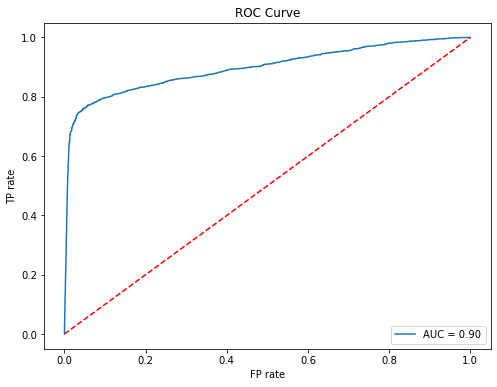

In [28]:
y_pred = rfc_sm.predict_proba(X_test)[:,1]
fp_r, tp_r, t = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fp_r, tp_r)
plt.figure(figsize=(8, 6))
plt.plot(fp_r, tp_r, label="AUC = %.2f" % auc)
plt.plot([0,1],[0,1],"r--")
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.legend(loc=4)
plt.title("ROC Curve")
plt.show()

In [29]:

plot_roc_curve(rfc_sm, X_train_os,  y_train_os)
plt.show()

C:\Users\conta\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


TypeError: '<' not supported between instances of 'DecisionTreeClassifier' and 'DecisionTreeClassifier'

### To search best parameters for Random Forest  and XGBoost i will use Random under sampling method It will help me  improve run time by reducing the number of training data samples, but it can discard potentially useful information which could be important for building rule classifiers. The sample chosen by random under-sampling may be a biased sample. And it will not be an accurate representation of the population. 

In [30]:
#Apply RUS

rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable
X_rus, y_rus = rus.fit_resample(X, y)

print(f'Original dataset shape:\n{ y.value_counts()}')
print(f'Resample dataset shape:\n{ y_rus.value_counts()}')

Original dataset shape:
0    1842743
1       9651
Name: is_fraud, dtype: int64
Resample dataset shape:
1    9651
0    9651
Name: is_fraud, dtype: int64


In [31]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [32]:
# Using the random grid to search for best hyperparameters
# First creating the base model to tune
rfc = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rfc_random.fit(X_rus, y_rus)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 24.9min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [33]:
rfc_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

In [34]:
def rfc_search(X,y, search_verbose=1):
    params = {'bootstrap': [True, False],
              'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
              'max_features': ['auto', 'sqrt'],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split': [2, 5, 10],
              'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
    
    rfc = RandomForestClassifier()

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    grid_search = GridSearchCV(estimator=rfc, param_grid=params, scoring="roc_auc", n_jobs=1, cv=skf.split(X,y), verbose=search_verbose)

    grid_search.fit(X,y)

    
    print(f'Best estimator:\n{grid_search.best_estimator_}')
    print("Parameters: ", grid_search.best_params_)
    print("Highest AUC: %.2f" % grid_search.best_score_)

    return grid_search.best_params_

In [35]:

rows = random.sample(np.arange(0,len(X_rus.index)).tolist(), 5000)
model_params = rfc_search(X_rus.iloc[rows,], y_rus.iloc[rows,])

Fitting 3 folds for each of 4320 candidates, totalling 12960 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 12960 out of 12960 | elapsed: 971.8min finished


Best estimator:
RandomForestClassifier(bootstrap=False, max_depth=50, n_estimators=600)
Parameters:  {'bootstrap': False, 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 600}
Highest AUC: 0.99


In [36]:

rfc.set_params(**model_params)
rfc.fit(X_rus, y_rus)

RandomForestClassifier(bootstrap=False, max_depth=50, n_estimators=600)

In [37]:
pred_rfc_us = rfc.predict(X_rus)
pred_rfc_us_test = rfc.predict(X_test)
print('Accuracy Train Score:', accuracy_score(y_rus, pred_rfc_us))
print('Accuracy Test Score:', accuracy_score(y_test, pred_rfc_us_test))
print('5 Cross val score:', cross_val_score(rfc, X_rus, y_rus, cv=5))
print('Cross val score:', cross_val_score(rfc, X_rus, y_rus, cv=5).mean())

Accuracy Train Score: 1.0
Accuracy Test Score: 0.9748523984243835
5 Cross val score: [0.96244496 0.95804196 0.9365285  0.94196891 0.92487047]
Cross val score: 0.9407295218694183


In [38]:
print(f'Confusion Matrix:\n{confusion_matrix(y_rus, pred_rfc_us)}')
print(f'Classification Report:\n{ classification_report(y_rus, pred_rfc_us)}')

Confusion Matrix:
[[9651    0]
 [   0 9651]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9651
           1       1.00      1.00      1.00      9651

    accuracy                           1.00     19302
   macro avg       1.00      1.00      1.00     19302
weighted avg       1.00      1.00      1.00     19302



In [39]:
print(f'Confusion Matrix:\n{confusion_matrix(y_test, pred_rfc_us_test)}')
print(f'Classification Report:\n{ classification_report(y_test, pred_rfc_us_test)}')

Confusion Matrix:
[[538849  13975]
 [     0   2895]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    552824
           1       0.17      1.00      0.29      2895

    accuracy                           0.97    555719
   macro avg       0.59      0.99      0.64    555719
weighted avg       1.00      0.97      0.98    555719



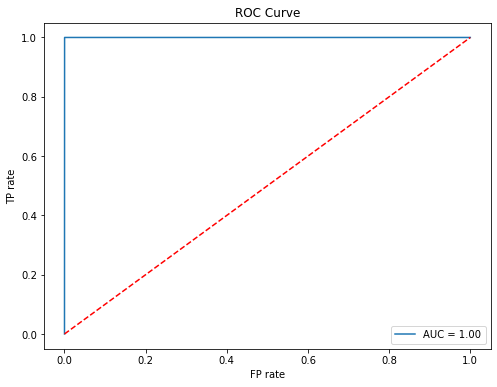

In [40]:
y_pred = rfc.predict_proba(X_test)[:,1]
fp_r, tp_r, t = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fp_r, tp_r)
plt.figure(figsize=(8, 6))
plt.plot(fp_r, tp_r, label="AUC = %.2f" % auc)
plt.plot([0,1],[0,1],"r--")
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.legend(loc=4)
plt.title("ROC Curve")
plt.show()

###  Now i'll train an XGBoost classifier, using the undersampled training set and  do a parameter search over the hyperparameters given in params
- The cross-validation strategy for each model uses 3 folds in a stratified KFold


In [41]:
def xgboost_search(X,y, search_verbose=1):
    params = {
    "gamma":[0.5, 1, 1.5, 2, 5],
    "max_depth":[3,4,5,6],
    "min_child_weight": [100],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "learning_rate": [0.1, 0.01, 0.001]
    }
    xgb = XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False)

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    grid_search = GridSearchCV(estimator=xgb, param_grid=params, scoring="roc_auc", n_jobs=1, cv=skf.split(X,y), verbose=search_verbose)

    grid_search.fit(X,y)

    print(f'Best estimator:\n{grid_search.best_estimator_}')
    print("Parameters: ", grid_search.best_params_)
    print("Highest AUC: %.2f" % grid_search.best_score_)

    return grid_search.best_params_

In [42]:
from sklearn.model_selection import StratifiedKFold
import random
rows = random.sample(np.arange(0,len(X_rus.index)).tolist(), 5000)
model_params = xgboost_search(X_rus.iloc[rows,], y_rus.iloc[rows,])

Fitting 3 folds for each of 540 candidates, totalling 1620 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1620 out of 1620 | elapsed:  8.1min finished


Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6,
              enable_categorical=False, eval_metric='auc', gamma=2, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=100, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1.0, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)
Parameters:  {'colsample_bytree': 0.6, 'gamma': 2, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 100, 'subsample': 1.0}
Highest AUC: 0.96


In [43]:
#Fitting 3 folds for each of 540 candidates, totalling 1620 fits
#Best estimator:
from numpy import nan
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, eval_metric='auc',
              gamma=1, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=100, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1.0, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)
Parameters:  {'colsample_bytree': 0.6, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 100, 'subsample': 1.0}


In [44]:
xgb = XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False)
xgb.set_params(**model_params)
xgb.fit(X_rus, y_rus)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6,
              enable_categorical=False, eval_metric='auc', gamma=2, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=100, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1.0, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [45]:
pred_xgb = xgb.predict(X_rus)
pred_xgb_test = xgb.predict(X_test)
print('Accuracy Train Score:', accuracy_score(y_rus, pred_xgb))
print('Accuracy Test Score:', accuracy_score(y_test, pred_xgb_test))
print('5 Cross val score:', cross_val_score(xgb, X_rus, y_rus, cv=5))
print('Cross val score:', cross_val_score(xgb, X_rus, y_rus, cv=5).mean())

Accuracy Train Score: 0.9294373640037302
Accuracy Test Score: 0.9461184519514358
5 Cross val score: [0.91919192 0.91427091 0.92487047 0.92098446 0.91476684]
Cross val score: 0.9188169190241731


In [46]:
print(f'Confusion Matrix:\n{confusion_matrix(y_rus, pred_xgb)}')
print(f'Classification Report:\n{ classification_report(y_rus, pred_xgb)}')

Confusion Matrix:
[[9177  474]
 [ 888 8763]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      9651
           1       0.95      0.91      0.93      9651

    accuracy                           0.93     19302
   macro avg       0.93      0.93      0.93     19302
weighted avg       0.93      0.93      0.93     19302



In [47]:
print(f'Confusion Matrix:\n{confusion_matrix(y_test, pred_xgb_test)}')
print(f'Classification Report:\n{ classification_report(y_test, pred_xgb_test)}')

Confusion Matrix:
[[523147  29677]
 [   266   2629]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    552824
           1       0.08      0.91      0.15      2895

    accuracy                           0.95    555719
   macro avg       0.54      0.93      0.56    555719
weighted avg       0.99      0.95      0.97    555719



In [ ]:
plot_roc_curve(xgb, X_rus, y_rus)
plt.show()

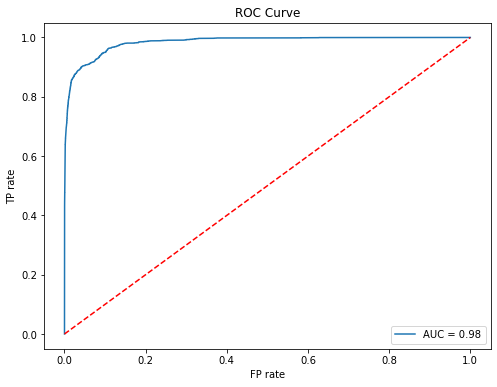

In [48]:
import sklearn.metrics as metrics 
y_pred = xgb.predict_proba(X_test)[:,1]
fp_r, tp_r, t = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fp_r, tp_r)
plt.figure(figsize=(8, 6))
plt.plot(fp_r, tp_r, label="AUC = %.2f" % auc)
plt.plot([0,1],[0,1],"r--")
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.legend(loc=4)
plt.title("ROC Curve")
plt.show()

In [49]:
#model.save_model("smote_fraud.xgb")

In [50]:
from sklearn.cluster import MiniBatchKMeans
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV


param_boost={'learning_rate':[0.01,0.1],
             'max_depth':[3,5,7],
             'sud_sample': [0.5,0.7],
             'colsample_bytree':[0.5,0.7],
             'n_estimators':[10,20,30]}
boost_grid= RandomizedSearchCV(XGBClassifier(),
                              param_boost, n_jobs=2)
boost_grid.fit(X_rus, y_rus)
prediction_boost=boost_grid.predict(X_test)

In [ ]:
y_pred = lr.predict_proba(X_test)[:,1]
fp_r, tp_r, t = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fp_r, tp_r)
plt.figure(figsize=(8, 6))
plt.plot(fp_r, tp_r, label="AUC = %.2f" % auc)
plt.plot([0,1],[0,1],"r--")
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.legend(loc=4)
plt.title("ROC Curve")
plt.show()

###  Unsupervised learning clustering techniques to detect fraud such as K-means and DBSCAN. Will take 10% sample from original data just to show the techniques.

In [ ]:
df_sample=df.sample(frac=0.1, random_state=42)

In [ ]:
df_sample.shape

In [ ]:
df_sample.is_fraud.value_counts()

In [ ]:
# Creating dummy variables for Category

X = pd.get_dummies(df_sample, columns=['category', 'gender', 'trans_year', 'trans_day', 'trans_month', 'trans_hour', 'age_at_trans', 'dist'],drop_first=True)
y = X.pop('is_fraud')

In [ ]:
# MinMax scaler apply to the data

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

### MiniBatch K-means is an efficient way to implement K-means on a large dataset, which I will use in this exercise. To decide which amount of clusters I'm going to use, let's apply the Elbow method and see what the optimal number of clusters should be based on this method.

In [ ]:
# Define the model

#kmeans = MiniBatchKMeans(n_clusters=8, random_state=0)

# Fit the model to the scaled data
#kmeans.fit(X_scaled)

In [ ]:
# Define the range of clusters to try
clustno = range(1, 10)

# Run MiniBatch Kmeans over the number of clusters
kmeans = [MiniBatchKMeans(n_clusters=i) for i in clustno]

# Obtain the score for each model
score = [kmeans[i].fit(X_scaled).score(X_scaled) for i in range(len(kmeans))]

In [ ]:
# Plot the models and their respective score 
plt.plot(clustno, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

### Now I can see that the optimal number of clusters should probably be at around 

In [ ]:

# Split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.3, random_state=0)

# Define K-means model 
kmeans = MiniBatchKMeans(n_clusters=6, random_state=42).fit(X_train)

# Obtain predictions and calculate distance from cluster centroid
X_test_clusters = kmeans.predict(X_test)
X_test_clusters_centers = kmeans.cluster_centers_
dist = [np.linalg.norm(x-y) for x, y in zip(X_test, X_test_clusters_centers[X_test_clusters])]

# Create fraud predictions based on outliers on clusters 
km_y_pred = np.array(dist)
km_y_pred[dist >= np.percentile(dist, 95)] = 1
km_y_pred[dist < np.percentile(dist, 95)] = 0

In [ ]:
# Define a function
def plot_confusion_matrix(cm, classes=['Not Fraud', 'Fraud'],
                          normalize=False,
                          title='Fraud Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
# Obtain the ROC score

roc_auc_score(y_test, km_y_pred)

In [ ]:
# Create a confusion matrix
km_cm = confusion_matrix(y_test, km_y_pred)

# Plot the confusion matrix in a figure to visualize results 
plot_confusion_matrix(km_cm)

In [ ]:
stop

### DBSCAN: Density-Based Spatial Clustering of Applications with Noise

In [ ]:
# Initialize and fit the DBscan model
db = DBSCAN(eps=0.9, min_samples=10, n_jobs=-1).fit(X_scaled)

# Obtain the predicted labels and calculate number of clusters
pred_labels = db.labels_
n_clusters = len(set(pred_labels)) - (1 if -1 in labels else 0)

In [ ]:
# Print performance metrics for DBscan
print(f'Estimated number of clusters: {n_clusters}')
print(f'Homogeneity: {homogeneity_score(labels, pred_labels):0.3f}')
print(f'Silhouette Coefficient: {silhouette_score(X_scaled, pred_labels):0.3f}')

In [ ]:
# Count observations in each cluster number
counts = np.bincount(pred_labels[pred_labels >= 0])

# Print the result
print(counts)

In [ ]:
# Sort the sample counts of the clusters and take the top 3 smallest clusters
smallest_clusters = np.argsort(counts)[:3]

In [ ]:
# Print the results 
print(f'The smallest clusters are clusters: {smallest_clusters}')

In [ ]:
# Print the counts of the smallest clusters only
print(f'Their counts are: {counts[smallest_clusters]}')

In [ ]:
# Create a dataframe of the predicted cluster numbers and fraud labels 
df = pd.DataFrame({'clusternr':pred_labels,'fraud':labels})

# Create a condition flagging fraud for the smallest clusters 
df['predicted_fraud'] = np.where((df['clusternr'].isin([21, 17, 9])), 1 , 0)

In [ ]:
# Run a crosstab on the results 
print(pd.crosstab(df['fraud'], df['predicted_fraud'], rownames=['Actual Fraud'], colnames=['Flagged Fraud']))

### Anomaly detection with Isolation Forest Algorithm  compare to Local Outlier Factor(LOF) Algorithm and OneClassSVM. Will take 10% sample from original data just to show the techniques.

In [ ]:
#Determine the number of fraud and valid transactions in the dataset
Fraud =df_samle[df_sample['is_fraud']==1]
Valid = df_sample[df_sample['is_fraud']==0]
outlier_fraction = len(Fraud)/float(len(Valid))

In [ ]:
print(outlier_fraction)

print("Fraud Cases : {}".format(len(Fraud)))

print("Valid Cases : {}".format(len(Valid)))

In [ ]:
#Create independent and Dependent Features
columns = df_sample.columns.tolist()
# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["is_fraud"]]
# Store the variable we are predicting 
target = "is_fraud"
# Define a random state 
state = np.random.RandomState(42)
X = df_sample[columns]
Y = df_sample[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

In [ ]:
#Define the outlier detection methods
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction,random_state=42, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1)
}

In [ ]:
n_outliers = len(Fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine": 
        clf.fit(X)
        y_pred = clf.predict(X)
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != y).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))

In [ ]:
# Results from other notebook
Isolation Forest: 1956
Accuracy Score :
0.9894406685417217
Confusion Matrix :
[[183264    981]
 [   975     19]]
Classification Report :
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    184245
           1       0.02      0.02      0.02       994

    accuracy                           0.99    185239
   macro avg       0.51      0.51      0.51    185239
weighted avg       0.99      0.99      0.99    185239

Local Outlier Factor: 1686
Accuracy Score :
0.9908982449700117
Confusion Matrix :
[[183399    846]
 [   840    154]]
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    184245
           1       0.15      0.15      0.15       994

    accuracy                           0.99    185239
   macro avg       0.57      0.58      0.57    185239
weighted avg       0.99      0.99      0.99    185239

Support Vector Machine: 82176
Accuracy Score :
0.5563785164031333
Confusion Matrix :
[[102560  81685]
 [   491    503]]
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.56      0.71    184245
           1       0.01      0.51      0.01       994

    accuracy                           0.56    185239
   macro avg       0.50      0.53      0.36    185239
weighted avg       0.99      0.56      0.71    185239